## 导库

In [5]:
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
import numpy as np
import os
import pandas as pd
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from tabulate import tabulate
from torchinfo import summary
%matplotlib inline

d:\Python\CondaEnvs\Pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 加载数据

In [7]:
train_data = "./data/Birds_25/train/"
test_data = "./data/Birds_25/valid/"

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()])

In [9]:
trainset = datasets.ImageFolder(root=train_data, transform=transform)
testset = datasets.ImageFolder(root=test_data, transform=transform)

In [10]:
print(f'Training dataset size: {len(trainset)}')
print(f'Testing dataset size: {len(testset)}')

Training dataset size: 30000
Testing dataset size: 7500


In [11]:
sample_img, label = trainset[3]
sample_img.shape, label

(torch.Size([3, 224, 224]), 0)

观察训练集数据

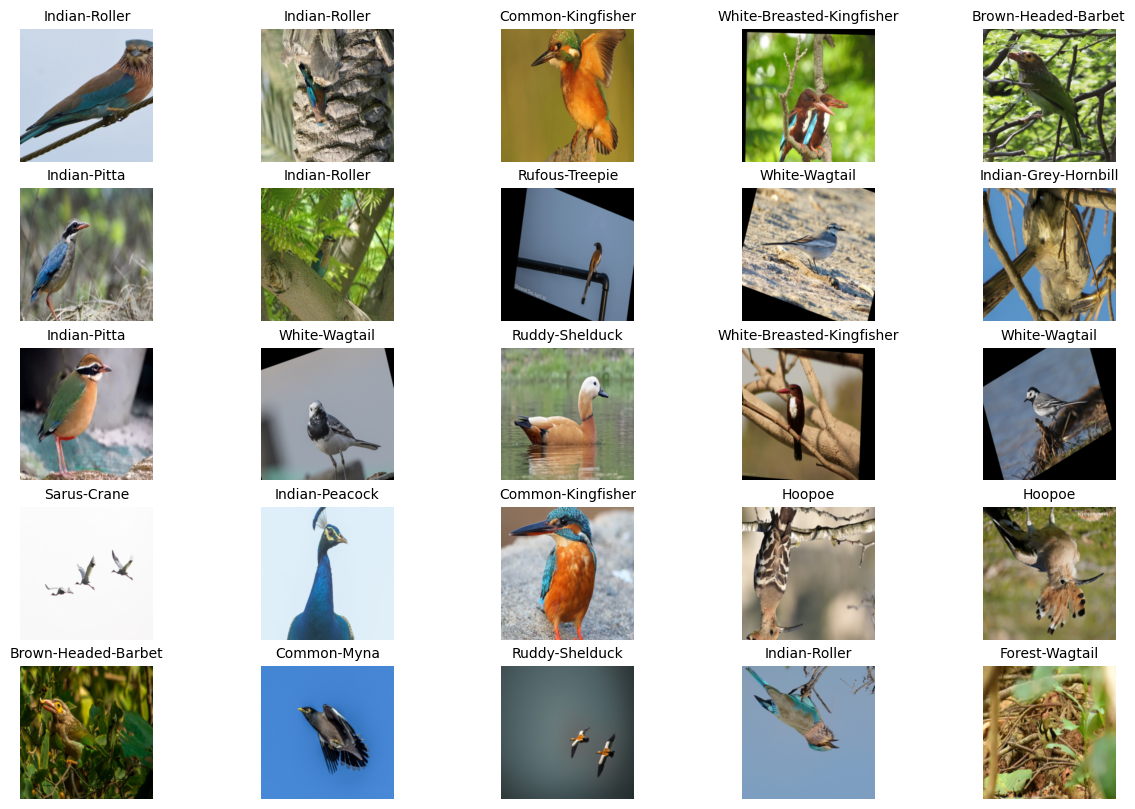

In [12]:
data_loader = torch.utils.data.DataLoader(
    trainset, batch_size=25, shuffle=True)
images, labels = next(iter(data_loader))
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
class_names = trainset.classes
for i in range(5):
    for j in range(5):
        idx = i*5+j

        ax[i, j].imshow(images[idx].permute(1, 2, 0))
        ax[i, j].set_title(class_names[labels[idx].item()], fontsize=10)
        ax[i, j].axis("off")
plt.show()

观察测试集数据

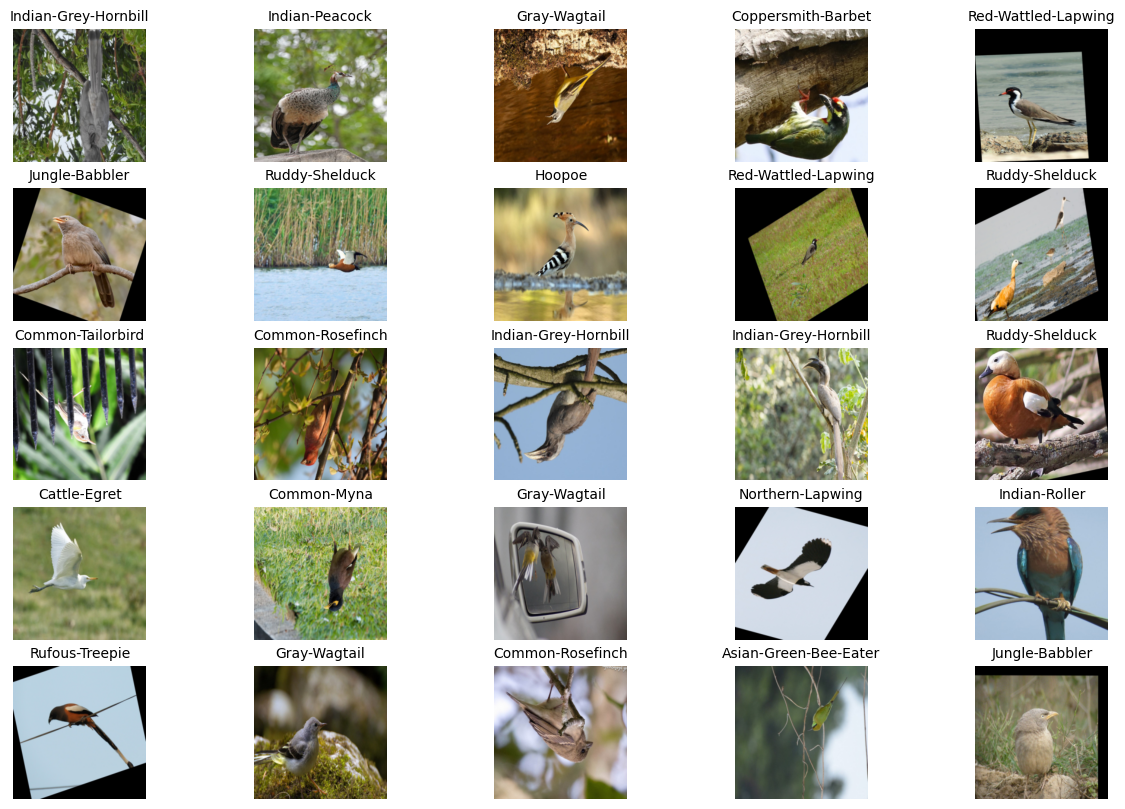

In [13]:
data_loader = torch.utils.data.DataLoader(testset, batch_size=25, shuffle=True)
images, labels = next(iter(data_loader))
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
class_names = testset.classes
for i in range(5):
    for j in range(5):
        idx = i*5+j

        ax[i, j].imshow(images[idx].permute(1, 2, 0))
        ax[i, j].set_title(class_names[labels[idx].item()], fontsize=10)
        ax[i, j].axis("off")
plt.show()

比较每一种类型有多少个

C:\Users\xiaof\AppData\Local\Temp\ipykernel_20264\3799243158.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(


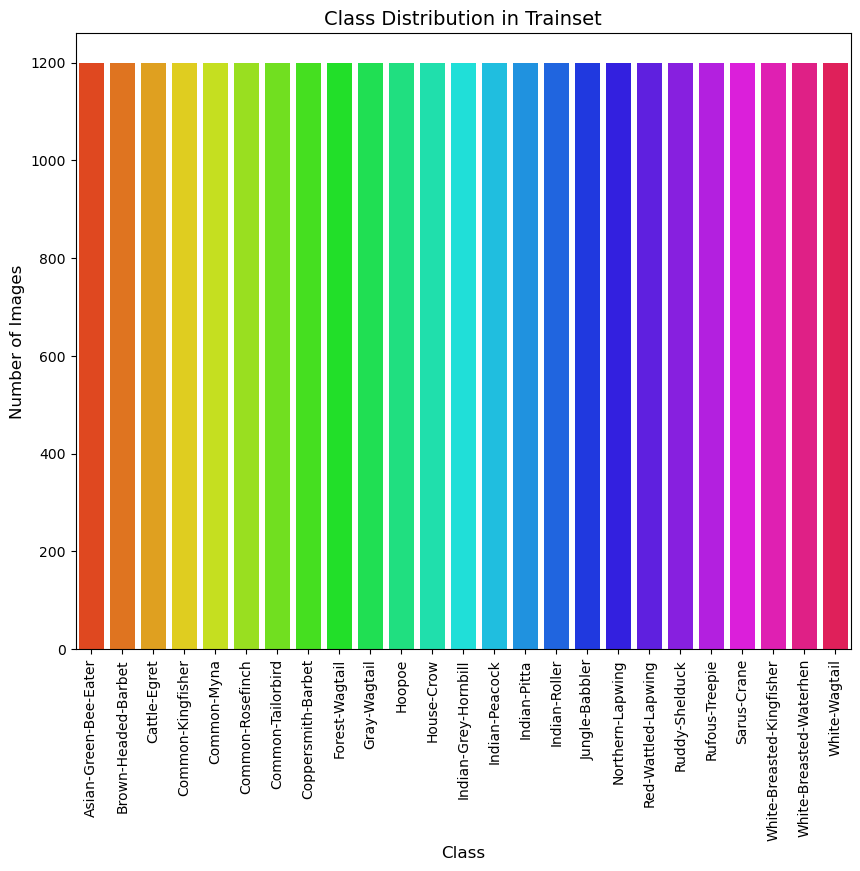

In [14]:
class_counts = Counter(trainset.targets)
class_names = trainset.classes
class_counts = {class_names[k]: v for k, v in class_counts.items()}

plt.figure(figsize=(10, 8))
sns.barplot(x=list(class_counts.keys()), y=list(
    class_counts.values()), palette="hsv")

plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=90)
plt.title("Class Distribution in Trainset", fontsize=14)

plt.show()

C:\Users\xiaof\AppData\Local\Temp\ipykernel_18228\1096061649.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=list(class_counts.keys()), x=list(


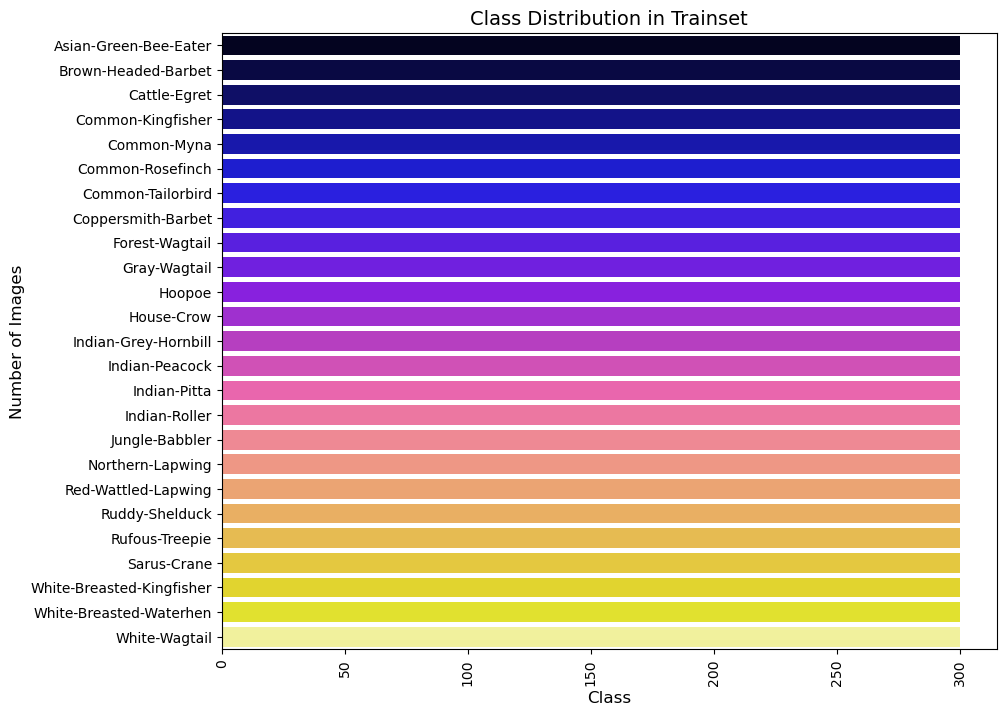

In [27]:
class_counts = Counter(testset.targets)
class_names = testset.classes
class_counts = {class_names[k]: v for k, v in class_counts.items()}

plt.figure(figsize=(10, 8))
sns.barplot(y=list(class_counts.keys()), x=list(
    class_counts.values()), palette="gnuplot2")

plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=90)
plt.title("Class Distribution in Trainset", fontsize=14)

plt.show()

### 创建数据加载器

In [15]:
train_data_loader = torch.utils.data.DataLoader(
    trainset, batch_size=16, shuffle=True, num_workers=8)
test_data_loader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=False, num_workers=8)

In [16]:
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


## 创建模型

In [17]:
class Bird_Image_Classifier_Simplified_Enhanced(nn.Module):
    def __init__(self, num_classes=25):
        super(Bird_Image_Classifier_Simplified_Enhanced, self).__init__()

        # First block (increased filters)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),  # Increased filters
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Second block (increased filters)
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Increased filters
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Third block (added another convolutional layer)
        self.conv3 = nn.Sequential(
            # Added more filters
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fourth block (added depth with extra convolution)
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # More filters
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Classifier (increased number of units)
        self.classifier = nn.Sequential(
            # Adjusted based on increased filters
            nn.Linear(512 * 14 * 14, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),  # Increased dropout
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):  # 输入，形状为[batch_size, 3, 224, 224]
        x = self.conv1(x)  # 形状为[batch_size, 128, 112, 112]
        x = self.conv2(x)  # 形状为[batch_size, 256, 56, 56]
        x = self.conv3(x)  # 形状为[batch_size, 512, 28, 28]
        x = self.conv4(x)  # 形状为[batch_size, 512, 14, 14]
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


# Model instantiation
model = Bird_Image_Classifier_Simplified_Enhanced()
summary(model, input_size=[16, 3, 224, 224])

Layer (type:depth-idx)                        Output Shape              Param #
Bird_Image_Classifier_Simplified_Enhanced     [16, 25]                  --
├─Sequential: 1-1                             [16, 128, 112, 112]       --
│    └─Conv2d: 2-1                            [16, 128, 224, 224]       3,584
│    └─BatchNorm2d: 2-2                       [16, 128, 224, 224]       256
│    └─ReLU: 2-3                              [16, 128, 224, 224]       --
│    └─MaxPool2d: 2-4                         [16, 128, 112, 112]       --
├─Sequential: 1-2                             [16, 256, 56, 56]         --
│    └─Conv2d: 2-5                            [16, 256, 112, 112]       295,168
│    └─BatchNorm2d: 2-6                       [16, 256, 112, 112]       512
│    └─ReLU: 2-7                              [16, 256, 112, 112]       --
│    └─MaxPool2d: 2-8                         [16, 256, 56, 56]         --
├─Sequential: 1-3                             [16, 512, 28, 28]         --
│    └─Con

### 创建优化器

In [18]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5, verbose=True)

d:\Python\CondaEnvs\Pytorch\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## 训练模型

In [33]:
epochs = 10
epoch_log = []
train_loss_log = []
train_accuracy_log = []
test_loss_log = []
test_accuracy_log = []
best_test_accuracy = 0
for epoch in range(epochs):
    print(f'Starting Epoch: {epoch+1}...')

    # Initialize variables for training loss and accuracy
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Set model to training mode
    model.train()

    # Create tqdm progress bar for training loop
    train_progress = tqdm(
        train_data_loader, desc=f'Epoch {epoch+1} Training', unit='batch')

    # Iterate through our train_data_loader iterator (mini-batches)
    for data in train_progress:
        inputs, labels = data

        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Ensure labels are long type for CrossEntropyLoss
        labels = labels.long()

        # Clear gradients before training
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update tqdm progress bar
        train_progress.set_postfix(
            loss=loss.item(), accuracy=100 * correct_train / total_train)

    # Calculate training loss and accuracy after each epoch
    train_loss = running_loss / len(train_data_loader)
    train_accuracy = 100 * correct_train / total_train

    # Initialize variables for test loss and accuracy
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    # Set model to evaluation mode
    model.eval()

    # We don't need gradients for validation, so we wrap it in no_grad()
    with torch.no_grad():
        # Create tqdm progress bar for testing loop
        test_progress = tqdm(
            test_data_loader, desc=f'Epoch {epoch+1} Testing', unit='batch')

        for data in test_progress:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Ensure labels are long type
            labels = labels.long()

            # Forward pass on the test data
            outputs = model(images)

            # Calculate loss
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()

            # Calculate test accuracy
            _, predicted = torch.max(outputs.data, dim=1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Update tqdm progress bar
            test_progress.set_postfix(
                loss=test_loss.item(), accuracy=100 * correct_test / total_test)

    # Calculate test loss and accuracy after each epoch
    test_loss = running_test_loss / len(test_data_loader)
    test_accuracy = 100 * correct_test / total_test

    # Step the scheduler based on test accuracy
    scheduler.step(test_accuracy)

    # Log training and testing metrics
    epoch_num = epoch + 1
    epoch_log.append(epoch_num)
    train_loss_log.append(train_loss)
    train_accuracy_log.append(train_accuracy)
    test_loss_log.append(test_loss)
    test_accuracy_log.append(test_accuracy)

    # Create table to display the results
    results_table = [
        ["Epoch", epoch_num],
        ["Train Loss", f"{train_loss:.3f}"],
        ["Train Accuracy", f"{train_accuracy:.3f}%"],
        ["Test Loss", f"{test_loss:.3f}"],
        ["Test Accuracy", f"{test_accuracy:.3f}%"],
        # Added learning rate display
        ["Learning Rate", f"{optimizer.param_groups[0]['lr']:.6f}"]
    ]

    # Print the table using tabulate
    print(tabulate(results_table, headers=[
          "Metric", "Value"], tablefmt="fancy_grid"))

print('Finished Training')

Starting Epoch: 1...


Epoch 1 Testing: 100%|██████████| 469/469 [00:52<00:00,  8.87batch/s, accuracy=48.7, loss=1.98] 


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 1        │
├────────────────┼──────────┤
│ Train Loss     │ 2.175    │
├────────────────┼──────────┤
│ Train Accuracy │ 31.753%  │
├────────────────┼──────────┤
│ Test Loss      │ 1.620    │
├────────────────┼──────────┤
│ Test Accuracy  │ 48.680%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 2...


Epoch 2 Testing: 100%|██████████| 469/469 [00:51<00:00,  9.04batch/s, accuracy=57.2, loss=1.54] 


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 2        │
├────────────────┼──────────┤
│ Train Loss     │ 1.528    │
├────────────────┼──────────┤
│ Train Accuracy │ 51.580%  │
├────────────────┼──────────┤
│ Test Loss      │ 1.350    │
├────────────────┼──────────┤
│ Test Accuracy  │ 57.200%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 3...


Epoch 3 Testing: 100%|██████████| 469/469 [00:52<00:00,  8.91batch/s, accuracy=69.8, loss=0.601] 


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 3        │
├────────────────┼──────────┤
│ Train Loss     │ 1.166    │
├────────────────┼──────────┤
│ Train Accuracy │ 63.060%  │
├────────────────┼──────────┤
│ Test Loss      │ 0.964    │
├────────────────┼──────────┤
│ Test Accuracy  │ 69.787%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 4...


Epoch 4 Testing: 100%|██████████| 469/469 [00:51<00:00,  9.04batch/s, accuracy=74.6, loss=1.09]  


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 4        │
├────────────────┼──────────┤
│ Train Loss     │ 0.896    │
├────────────────┼──────────┤
│ Train Accuracy │ 71.690%  │
├────────────────┼──────────┤
│ Test Loss      │ 0.813    │
├────────────────┼──────────┤
│ Test Accuracy  │ 74.560%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 5...


Epoch 5 Testing: 100%|██████████| 469/469 [00:50<00:00,  9.20batch/s, accuracy=77.7, loss=0.245]  


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 5        │
├────────────────┼──────────┤
│ Train Loss     │ 0.687    │
├────────────────┼──────────┤
│ Train Accuracy │ 78.220%  │
├────────────────┼──────────┤
│ Test Loss      │ 0.709    │
├────────────────┼──────────┤
│ Test Accuracy  │ 77.747%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 6...


Epoch 6 Testing: 100%|██████████| 469/469 [00:51<00:00,  9.11batch/s, accuracy=80.5, loss=0.438] 


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 6        │
├────────────────┼──────────┤
│ Train Loss     │ 0.494    │
├────────────────┼──────────┤
│ Train Accuracy │ 84.097%  │
├────────────────┼──────────┤
│ Test Loss      │ 0.642    │
├────────────────┼──────────┤
│ Test Accuracy  │ 80.480%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 7...


Epoch 7 Testing: 100%|██████████| 469/469 [00:51<00:00,  9.19batch/s, accuracy=78.1, loss=0.00484]


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 7        │
├────────────────┼──────────┤
│ Train Loss     │ 0.361    │
├────────────────┼──────────┤
│ Train Accuracy │ 88.177%  │
├────────────────┼──────────┤
│ Test Loss      │ 0.762    │
├────────────────┼──────────┤
│ Test Accuracy  │ 78.133%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 8...


Epoch 8 Testing: 100%|██████████| 469/469 [00:49<00:00,  9.42batch/s, accuracy=81.7, loss=0.0739] 


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 8        │
├────────────────┼──────────┤
│ Train Loss     │ 0.280    │
├────────────────┼──────────┤
│ Train Accuracy │ 90.793%  │
├────────────────┼──────────┤
│ Test Loss      │ 0.654    │
├────────────────┼──────────┤
│ Test Accuracy  │ 81.653%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 9...


Epoch 9 Testing: 100%|██████████| 469/469 [00:50<00:00,  9.28batch/s, accuracy=81.3, loss=0.117]  


╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 9        │
├────────────────┼──────────┤
│ Train Loss     │ 0.211    │
├────────────────┼──────────┤
│ Train Accuracy │ 92.980%  │
├────────────────┼──────────┤
│ Test Loss      │ 0.730    │
├────────────────┼──────────┤
│ Test Accuracy  │ 81.320%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Starting Epoch: 10...


Epoch 10 Testing: 100%|██████████| 469/469 [00:49<00:00,  9.43batch/s, accuracy=81.8, loss=1.18]   

╒════════════════╤══════════╕
│ Metric         │ Value    │
╞════════════════╪══════════╡
│ Epoch          │ 10       │
├────────────────┼──────────┤
│ Train Loss     │ 0.189    │
├────────────────┼──────────┤
│ Train Accuracy │ 93.850%  │
├────────────────┼──────────┤
│ Test Loss      │ 0.694    │
├────────────────┼──────────┤
│ Test Accuracy  │ 81.800%  │
├────────────────┼──────────┤
│ Learning Rate  │ 0.001000 │
╘════════════════╧══════════╛
Finished Training


### 保存模型

In [36]:
path = "./model"
os.makedirs(path, exist_ok=True)
print(f"Directory created : {path}")

Directory created : ./model


In [37]:
model_path = os.path.join(path, "avian_classifier.pth")
torch.save(model.state_dict(), model_path)

## 评估

### 可视化损失

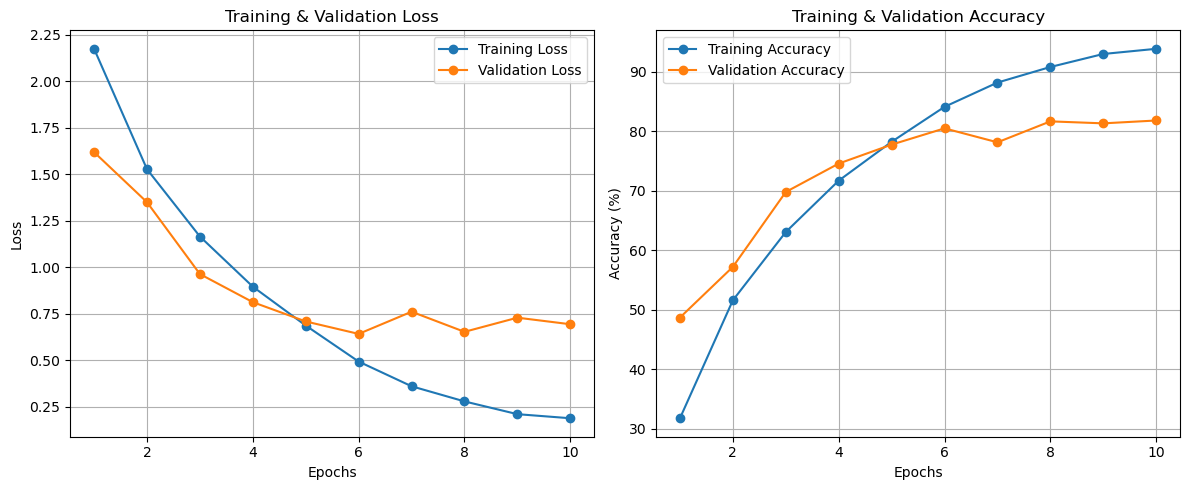

In [38]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_log, train_loss_log, label='Training Loss', marker='o')
plt.plot(epoch_log, test_loss_log, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epoch_log, train_accuracy_log, label='Training Accuracy', marker='o')
plt.plot(epoch_log, test_accuracy_log, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 预测

In [39]:
class_names = train_data_loader.dataset.classes
num_classes = len(class_names)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    test_progress = tqdm(
        test_data_loader, desc="Generating Predictions", unit="batch")

    for data in test_progress:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Generating Predictions: 100%|██████████| 469/469 [00:49<00:00,  9.41batch/s]


### 混淆矩阵

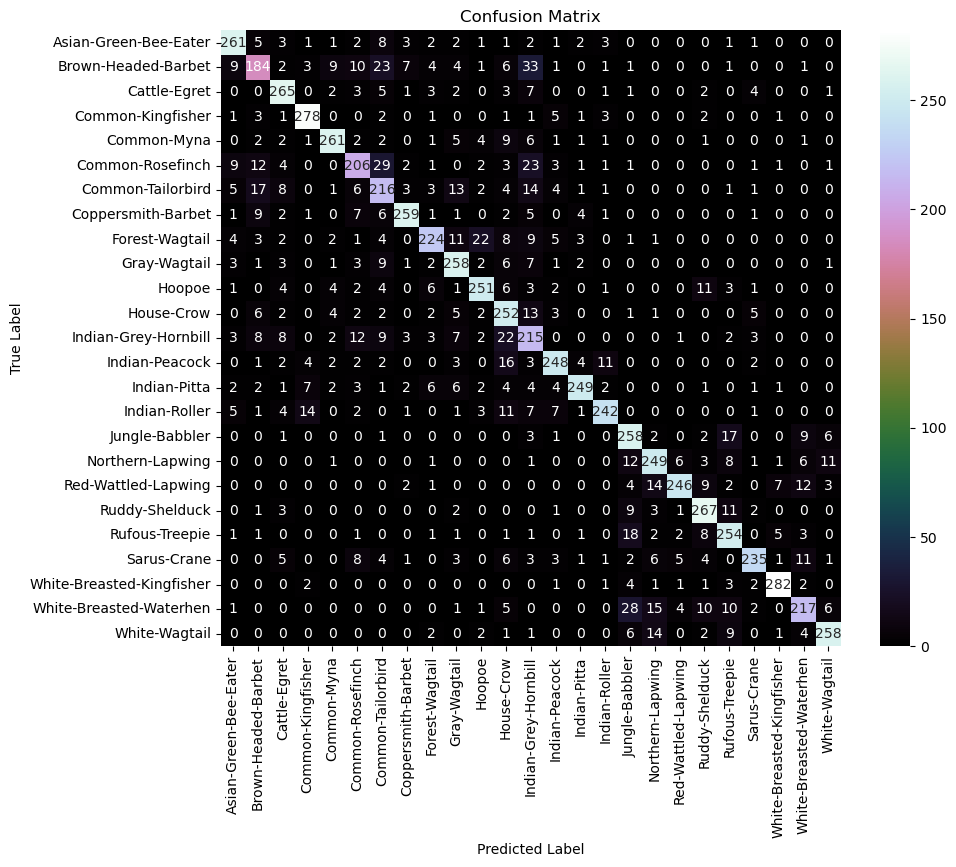

In [40]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="cubehelix",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 分类报告

In [41]:
print(classification_report(all_labels, all_preds, target_names=class_names))

                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.85      0.87      0.86       300
      Brown-Headed-Barbet       0.72      0.61      0.66       300
             Cattle-Egret       0.82      0.88      0.85       300
        Common-Kingfisher       0.89      0.93      0.91       300
              Common-Myna       0.89      0.87      0.88       300
         Common-Rosefinch       0.76      0.69      0.72       300
        Common-Tailorbird       0.66      0.72      0.69       300
       Coppersmith-Barbet       0.91      0.86      0.89       300
           Forest-Wagtail       0.85      0.75      0.79       300
             Gray-Wagtail       0.79      0.86      0.82       300
                   Hoopoe       0.85      0.84      0.84       300
               House-Crow       0.69      0.84      0.76       300
     Indian-Grey-Hornbill       0.60      0.72      0.65       300
           Indian-Peacock       0.85      0.83      0.84     

### ROC曲线

Computing Probabilities: 100%|██████████| 469/469 [00:49<00:00,  9.50batch/s]


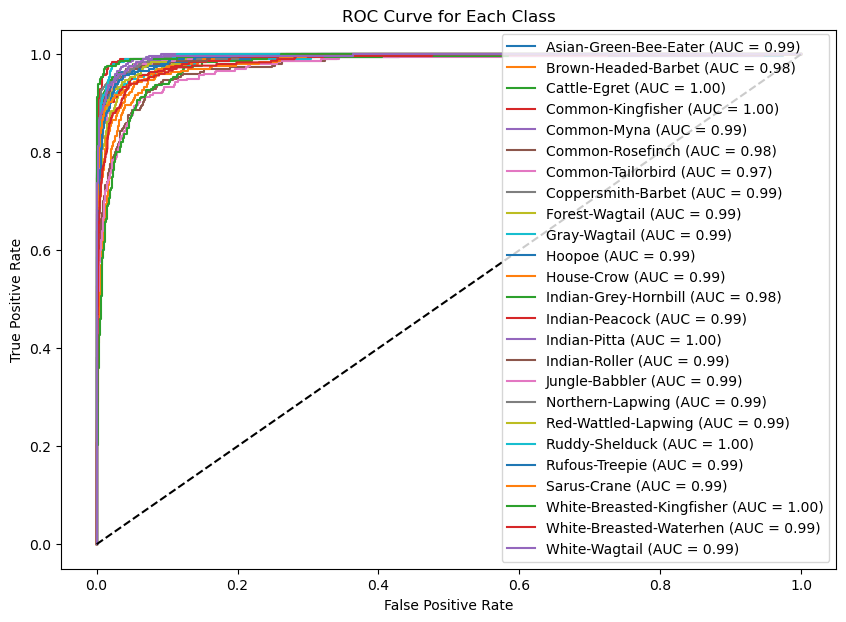

In [42]:
num_classes = len(class_names)
all_labels_one_hot = label_binarize(all_labels, classes=np.arange(num_classes))

with torch.no_grad():
    all_outputs = []
    for data in tqdm(test_data_loader, desc="Computing Probabilities", unit="batch"):
        images, _ = data
        images = images.to(device)
        outputs = model(images)
        all_outputs.extend(outputs.cpu().numpy())

all_outputs = np.array(all_outputs)
all_probs = torch.nn.functional.softmax(
    torch.tensor(all_outputs), dim=1).numpy()

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

### PRC曲线

Computing Probabilities: 100%|██████████| 469/469 [00:50<00:00,  9.27batch/s]


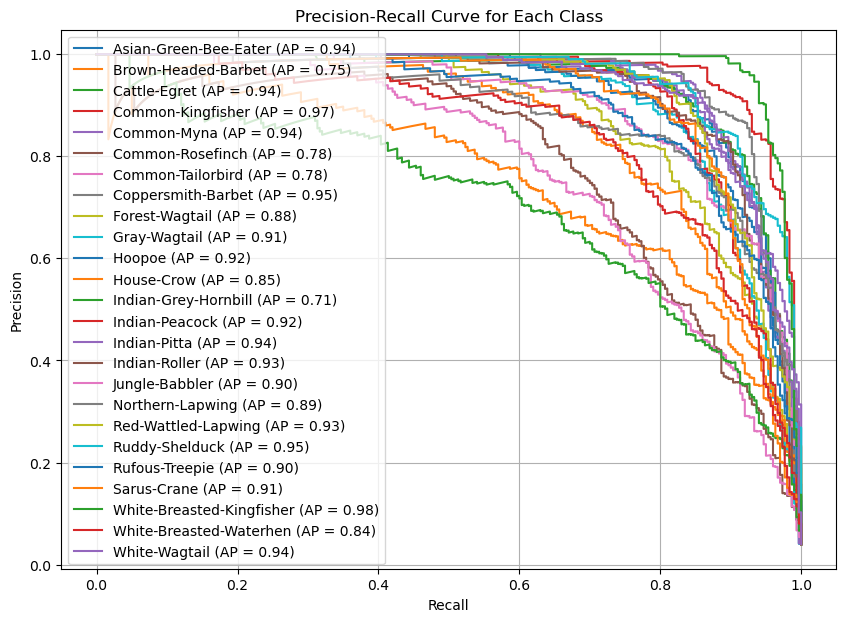

In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

num_classes = len(class_names)
all_labels_one_hot = label_binarize(all_labels, classes=np.arange(num_classes))

with torch.no_grad():
    all_outputs = []
    for data in tqdm(test_data_loader, desc="Computing Probabilities", unit="batch"):
        images, _ = data
        images = images.to(device)
        outputs = model(images)  # [batch_size, num_classes]
        all_outputs.extend(outputs.cpu().numpy())

all_outputs = np.array(all_outputs)
all_probs = torch.nn.functional.softmax(
    torch.tensor(all_outputs), dim=1).numpy()

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(
        all_labels_one_hot[:, i], all_probs[:, i])
    avg_precision = average_precision_score(
        all_labels_one_hot[:, i], all_probs[:, i])
    plt.plot(recall, precision,
             label=f"{class_name} (AP = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend(loc="best")
plt.grid()
plt.show()

### 每一种类别的准确率

In [ ]:
class_correct = [0. for _ in range(num_classes)]
class_total = [0. for _ in range(num_classes)]

# We don't need gradients for validation
with torch.no_grad():
    test_progress = tqdm(test_data_loader, desc="Evaluating", unit="batch")

    for data in test_progress:
        images, labels = data

        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # shape of predicted: [batch_size, 1]
        # Compare predictions to true labels
        c = (predicted == labels).squeeze()

        # Iterate dynamically based on batch size
        for i in range(labels.shape[0]):  # shape of labels: [batch_size]
            label = labels[i].item()  # Ensure it's an integer index
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print accuracy for each class
for i in range(num_classes):
    if class_total[i] > 0:  # Avoid division by zero
        class_accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy of {class_names[i]}: {class_accuracy:.3f}%')
    else:
        print(f'Accuracy of {class_names[i]}: No samples found')

### 展示36张预测图片

In [ ]:
model.eval()

# Define the number of images to plot
num_images = 36

# Create a figure for displaying images
fig, axes = plt.subplots(6, 6, figsize=(20, 20))

# Assuming class_names is already defined, e.g.:
# class_names = ['class1', 'class2', ..., 'class10']

# No gradient calculations for efficiency
with torch.no_grad():
    images_plotted = 0  # Counter to track the number of images plotted

    # Use tqdm to show progress bar
    test_loader = tqdm(
        test_data_loader, desc="Processing Batches", unit="batch")

    for data in test_loader:
        images, labels = data

        # Move to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Model predictions
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        for i in range(images.shape[0]):
            pred = predictions[i].item()
            label = labels[i].item()

            # Select subplot
            ax = axes[images_plotted // 6, images_plotted % 6]

            # Convert tensor image to numpy and transpose (C, H, W) → (H, W, C)
            img = images[i].cpu().numpy().transpose(1, 2, 0)

            # Display the image
            ax.imshow(img)  # Remove cmap='gray' since it's RGB
            ax.axis('off')

            # Map the numeric labels to class names
            label_name = class_names[label]
            pred_name = class_names[pred]

            # Title color based on correctness
            color = 'green' if pred == label else 'red'
            ax.set_title(f'GT: {label_name}\nPred: {pred_name}',
                         color=color, fontsize=10)

            images_plotted += 1

            # Stop once we plot 36 images
            if images_plotted >= num_images:
                break

        if images_plotted >= num_images:
            break

plt.tight_layout()
plt.show()

## 可视化用户界面

### 计算均值和标准差

In [49]:
# Calculate mean and std
means = []
stds = []

# Convert dataset to numpy array and calculate statistics
for images, _ in test_data_loader:
    # Move channel dimension to the end for numpy calculations
    numpy_images = images.numpy().transpose(0, 2, 3, 1)

    # Calculate mean and std for this batch
    batch_mean = numpy_images.mean(axis=(0, 1, 2))
    batch_std = numpy_images.std(axis=(0, 1, 2))

    means.append(batch_mean)
    stds.append(batch_std)

# Calculate overall mean and std
mean = np.array(means).mean(axis=0)  # 按照列取均值
std = np.array(stds).mean(axis=0)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.47142678 0.48106232 0.40238315]
Std: [0.23357268 0.23068522 0.25513577]


### 加载界面

In [20]:
import gradio as gr
from torchvision import transforms
from PIL import Image

path = "./model/avian_classifier.pth"

model.load_state_dict(torch.load(path, weights_only=True))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])


def predict(image):
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0)
    image = image.to("cuda")  # Assuming using GPU, else use "cpu"

    with torch.no_grad():
        output = model(image)

    _, predicted = torch.max(output, 1)
    return class_names[predicted.item()]


iface = gr.Interface(fn=predict,
                     inputs=gr.Image(type="numpy", image_mode="RGB"),
                     outputs="text",
                     live=False,
                     title="Avian Classifier",
                     description="Upload an image of a bird to get its predicted class")

iface.launch()

NameError: name 'mean' is not defined